In [1]:
# import packages
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import argparse

# create neural network
class RoadSignClassifier:
    def createCNN(width, height, depth, classes):
        model = Sequential()
        inputShape = (height, width, depth)
        model.add(Conv2D(8, (5, 5), input_shape=inputShape, activation="relu"))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(16, (3, 3), activation="relu"))
        model.add(BatchNormalization())
        model.add(Conv2D(16, (3, 3), activation="relu"))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(32, (3, 3), padding="same", activation="relu"))
        model.add(BatchNormalization())
        model.add(Conv2D(32, (3, 3), padding="same", activation="relu"))
        model.add(BatchNormalization())
        model.add(Flatten())
        model.add(Dropout(0.5))
        model.add(Dense(512, activation="relu"))
        model.add(Dense(classes, activation="softmax"))
        return model


# read images and resize
data_path = r"/Users/hdai/Documents/Junior Year/SML310/Final Project/TSRD"
def load_data(dataset):
    images = []
    classes = []
    rows = pd.read_csv(dataset)
    rows = rows.sample(frac=1).reset_index(drop=True)
    for i, row in rows.iterrows():
        img_class = row["ClassId"]
        img_path = row["Path"]
        image = os.path.join(data_path, img_path)
        image = cv2.imread(image)
        image_rs = cv2.resize(image, (32, 32), 3)
        R, G, B = cv2.split(image_rs)
        img_r = cv2.equalizeHist(R)
        img_g = cv2.equalizeHist(G)
        img_b = cv2.equalizeHist(B)
        new_image = cv2.merge((img_r, img_g, img_b))
        if i % 500 == 0:
            print(f"loaded: {i}")
        images.append(new_image)
        classes.append(img_class)
    X = np.array(images)
    y = np.array(classes)
    
    return (X, y)

#ap = argparse.ArgumentParser()
#ap.add_argument("-m", "--model", default="output/trafficsignnet.model", help="path to output model")
#args = vars(ap.parse_args())

# set conditions
epochs = 100
learning_rate = 0.001
batch_size = 64

#Run this part for the first time and save the pre-processed data. So you do not have to process it every time
#train_data = r"/Users/hdai/Documents/Junior Year/SML310/Final Project/GTSRB/Train.csv"
#test_data = r"/Users/hdai/Documents/Junior Year/SML310/Final Project/GTSRB/Test.csv"
#(train_X, train_Y) = load_data(train_data)
#(test_X, test_Y) = load_data(test_data)
#np.save('GTSD_trainX',train_X)
#np.save('GTSD_trainY',train_Y)
#np.save('GTSD_testX',test_X)
#np.save('GTSD_testY',test_Y)

# load data
train_X = np.load('TSRD_trainX.npy', allow_pickle=True)
test_X = np.load('TSRD_testX.npy', allow_pickle=True)
train_Y = np.load('TSRD_trainY.npy', allow_pickle=True)
test_Y = np.load('TSRD_testY.npy', allow_pickle=True)
print("UPDATE: Normalizing data")
trainX = train_X.astype("float32") / 255.0
testX = test_X.astype("float32") / 255.0
print("UPDATE: One-Hot Encoding data")
num_labels = len(np.unique(train_Y))
trainY = to_categorical(train_Y, num_labels)
testY = to_categorical(test_Y, num_labels)

class_totals = trainY.sum(axis=0)
class_weight = class_totals.max() / class_totals

# data augmentation
data_aug = ImageDataGenerator(
rotation_range=10,
zoom_range=0.15,
width_shift_range=0.1,
height_shift_range=0.1,
shear_range=0.15,
horizontal_flip=False,
vertical_flip=False)

# train model
model = RoadSignClassifier.createCNN(width=32, height=32, depth=3, classes=58)
optimizer = Adam(learning_rate=learning_rate, decay=learning_rate / (epochs))
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
fit = model.fit(
    data_aug.flow(trainX, trainY, batch_size=batch_size), 
    epochs=epochs,
    validation_data=(testX, testY),
    # class_weight=class_weight,
    verbose=1)
model.save("output/chinesetrafficsignnet.model")

UPDATE: Normalizing data
UPDATE: One-Hot Encoding data
Epoch 1/100
66/66 [==============================] - 11s 145ms/step - loss: 2.6618 - accuracy: 0.3372 - val_loss: 3.8509 - val_accuracy: 0.0160
Epoch 2/100
66/66 [==============================] - 8s 114ms/step - loss: 1.5066 - accuracy: 0.5650 - val_loss: 3.8000 - val_accuracy: 0.0732
Epoch 3/100
66/66 [==============================] - 8s 123ms/step - loss: 1.1424 - accuracy: 0.6638 - val_loss: 4.1901 - val_accuracy: 0.0682
Epoch 4/100
66/66 [==============================] - 9s 130ms/step - loss: 0.9592 - accuracy: 0.7046 - val_loss: 3.7589 - val_accuracy: 0.1775
Epoch 5/100
66/66 [==============================] - 8s 119ms/step - loss: 0.8120 - accuracy: 0.7484 - val_loss: 3.5260 - val_accuracy: 0.2538
Epoch 6/100
66/66 [==============================] - 7s 103ms/step - loss: 0.7187 - accuracy: 0.7767 - val_loss: 2.3813 - val_accuracy: 0.4473
Epoch 7/100
66/66 [==============================] - 7s 100ms/step - loss: 0.6925 - ac

66/66 [==============================] - 11s 162ms/step - loss: 0.0814 - accuracy: 0.9722 - val_loss: 2.8601 - val_accuracy: 0.5878
Epoch 58/100
66/66 [==============================] - 11s 161ms/step - loss: 0.1181 - accuracy: 0.9650 - val_loss: 2.3446 - val_accuracy: 0.6510
Epoch 59/100
66/66 [==============================] - 11s 166ms/step - loss: 0.0946 - accuracy: 0.9691 - val_loss: 2.7412 - val_accuracy: 0.5577
Epoch 60/100
66/66 [==============================] - 11s 159ms/step - loss: 0.0762 - accuracy: 0.9765 - val_loss: 2.6837 - val_accuracy: 0.6108
Epoch 61/100
66/66 [==============================] - 11s 168ms/step - loss: 0.0866 - accuracy: 0.9686 - val_loss: 2.2574 - val_accuracy: 0.6600
Epoch 62/100
66/66 [==============================] - 11s 163ms/step - loss: 0.1093 - accuracy: 0.9667 - val_loss: 2.1539 - val_accuracy: 0.6720
Epoch 63/100
66/66 [==============================] - 11s 159ms/step - loss: 0.1019 - accuracy: 0.9679 - val_loss: 2.0631 - val_accuracy: 0.677

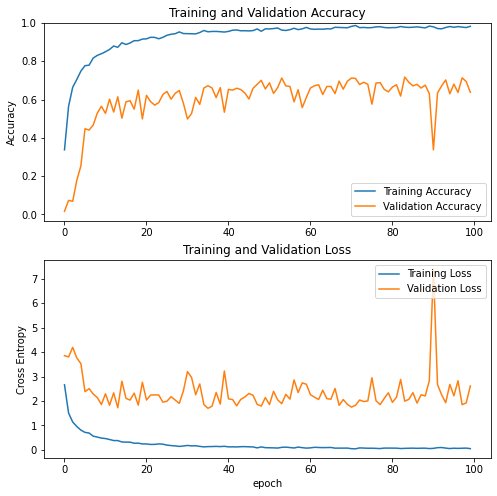

In [2]:
acc = fit.history['accuracy']
val_acc = fit.history['val_accuracy']

loss = fit.history['loss']
val_loss = fit.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

np.save('TSRD_Individual_Learning', [acc,loss,val_acc,val_loss])